In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [3]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics')
figfolder.mkdir(parents=True, exist_ok=True)

In [4]:
c = nmp.connectomics.npt_client()

In [5]:
ebcoords = nmp.connectomics.EBCoordinateSystem()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/connectomics.py:150: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=92). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  self._xsec_rad_spline = sp.interpolate.LSQBivariateSpline(eb_phase, xsec_phase, xsec_rad, knots, knots)


In [6]:
def add_eb_coords(syn_df, ebcoords, type='post'):
    syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']] = ebcoords.change_of_basis(syn_df.loc[:,[f'x_{type}', f'y_{type}', f'z_{type}']].values)
    syn_df.loc[:, ['y_eb', 'z_eb']] = -1*syn_df.loc[:,['y_eb','z_eb']]
    phase, radius = ebcoords.get_circ_coordinates(syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']].values)
    syn_df['phase'], syn_df['radius'] = phase, radius
    syn_df['radius_scaled'] = ebcoords.scale_radius(syn_df['phase'],syn_df['radius'])
    syn_df['xsec_phase'], syn_df['xsec_radius'] = ebcoords.get_xsec_coords(syn_df['phase'],syn_df['radius'], syn_df['z_eb'])
    syn_df['xsec_radius_scaled'] = ebcoords.scale_xsec_rad(syn_df['phase'], 
                                                            syn_df['xsec_phase'], 
                                                            syn_df['xsec_radius'])

    syn_df['xsec_x'] = syn_df['xsec_radius']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y'] = syn_df['xsec_radius']*np.sin(syn_df['xsec_phase'])
    syn_df['xsec_x_scaled'] = syn_df['xsec_radius_scaled']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y_scaled'] = syn_df['xsec_radius_scaled']*np.sin(syn_df['xsec_phase'])


In [7]:
# cmap = sns.color_palette(palette='mako',as_cmap=True)
# cmap = sns.light_palette("seagreen", as_cmap=True)
cmap = sns.color_palette("hls", 18, as_cmap=True)
angle_2_color = lambda phase : cmap((phase+np.pi)/2/np.pi)



In [8]:
# 
els, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EL'))
example_el = neu.fetch_skeletons(els.iloc[0]['bodyId'])

In [9]:
nodes = example_el.nodes.copy()
nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
nodes.loc[:,'z'] = -nodes.loc[:,'z']
nodes.head()
example_el.set_neuron_attributes(nodes,name='nodes')

In [10]:
def peeled_convex_hull(syn_points, n=20):
    """
    Peel off the convex hull of synapses n times.
    Parameters
    ----------
    syn_points : np.ndarray
        Array of synapse coordinates in 2D.
    n : int, optional
        Number of times to peel off the convex hull, by default 20.
    Returns
    -------
    np.ndarray
        The coordinates of the convex hull remaining synapses after peeling off the convex hull n times.
    """
    syn_points = syn_points.copy()
    for i in range(n):
        syn_hull = sp.spatial.ConvexHull(syn_points)
        syn_points = np.delete(syn_points, syn_hull.vertices, axis=0)
    return syn_points[sp.spatial.ConvexHull(syn_points).vertices,:]

In [11]:
eb = neu.fetch_roi("EB")
eb.vertices = ebcoords.eb_vertices
eb.vertices[:,1] = -eb.vertices[:,1]  # flip y axis to match EB coordinates
eb.vertices[:,2] = -eb.vertices[:,2]

pb = neu.fetch_roi("PB")
pb.vertices = ebcoords.change_of_basis(pb.vertices)
pb.vertices[:,1] = -pb.vertices[:,1]  # flip y axis to match EB coordinates
pb.vertices[:,2] = -pb.vertices[:,2]

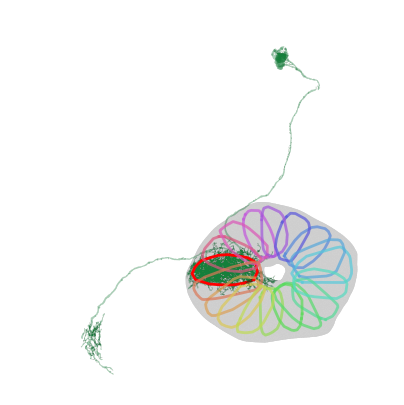

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, example_el,],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Greens(.8), plt.cm.Greys(.3)),
                alpha=.2,
                radius=True,
                ax=ax,
                # volume_outlines=True,
            )
ax.grid(False)

colors = []
for i, row in els.iterrows():
        syn = neu.fetch_synapses(row['bodyId'],
                                neu.SynapseCriteria(rois=['EB'], type='pre'))

        syn.loc[:,('x','y','z')] = ebcoords.change_of_basis(syn.loc[:,('x','y','z')].values)
        syn.loc[:,'y'] = -syn.loc[:,'y']  # flip y axis to match EB coordinates
        syn.loc[:, 'z'] = -syn.loc[:,'z']
        syn_hull_vertices = peeled_convex_hull(syn.loc[:,('x','y')].values, n=10)
        phase = np.angle(np.exp(1j*np.arctan2(syn_hull_vertices[:,1], syn_hull_vertices[:,0])).mean(axis=0))
        
        if i == 0:
                color = 'red'
                alpha = 1.0
        else:
                color = angle_2_color(phase)
                alpha = .7
        ax.plot(syn_hull_vertices[:,0], syn_hull_vertices[:,1], color=color, lw=2, label='Convex Hull', alpha=alpha, zorder=100)
        ax.plot([syn_hull_vertices[-1,0], syn_hull_vertices[0,0]],
                [syn_hull_vertices[-1,1], syn_hull_vertices[0,1]], color=color, lw=2, label='Convex Hull', alpha=alpha,zorder=10+i)
        colors.append(color)


ax.set_xlim([-15000, 7000])
ax.set_ylim([-7000, 15000])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for b in ['top', 'right', 'left', 'bottom']:
        ax.spines[b].set_visible(False)

fig.savefig(figfolder / 'example_el_cvx_hulls.pdf')
fig.savefig(figfolder / 'example_el_cvx_hulls.png', transparent=True, dpi = 500)


In [13]:
# fetch synapse locations from EPG to example EL
epg_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = 'EPG'), els['bodyId'].iloc[0]) #, synapse_criteria=neu.SynapseCriteria(rois=('EB')))
pen_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = 'PEN_a.*'), els['bodyId'].iloc[0]) #, synapse_criteria=neu.SynapseCriteria(rois=('EB')))

# fetch synapses from example EL to R4d and R2
er_syn = neu.fetch_synapse_connections(els['bodyId'].iloc[0], neu.NeuronCriteria(type = ['ER4d', 'ER2_a', 'ER2_b', 'ER2_c','ER2_d']), synapse_criteria=neu.SynapseCriteria(rois=('EB')))


add_eb_coords(epg_syn, ebcoords, type='post')
add_eb_coords(er_syn, ebcoords, type='pre')
add_eb_coords(pen_syn, ebcoords, type='post')



  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

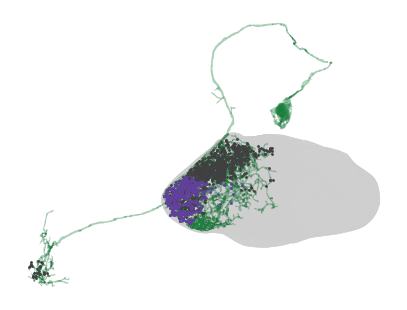

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, example_el,],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "z"),
                color=(plt.cm.Greens(.8), plt.cm.Greys(.3)),
                alpha=.2,
                radius=True,
                ax=ax,
                # volume_outlines=True,
            )
ax.grid(False)

ax.scatter(epg_syn['x_eb'], epg_syn['z_eb'], color=plt.cm.Greys(.8), s=1,alpha=1, zorder=100)
ax.scatter(er_syn['x_eb'], er_syn['z_eb'], color=plt.cm.Purples(.8), s=1, alpha=1, zorder=100)
ax.scatter(pen_syn['x_eb'], pen_syn['z_eb'], color=plt.cm.Greys(.8), s=1, alpha=1, zorder=100)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for b in ['top', 'right', 'left', 'bottom']:
        ax.spines[b].set_visible(False)

fig.savefig(figfolder / 'example_el_xsec_syns.pdf')
fig.savefig(figfolder / 'example_el_xsec_syns.png', transparent=True, dpi=500)


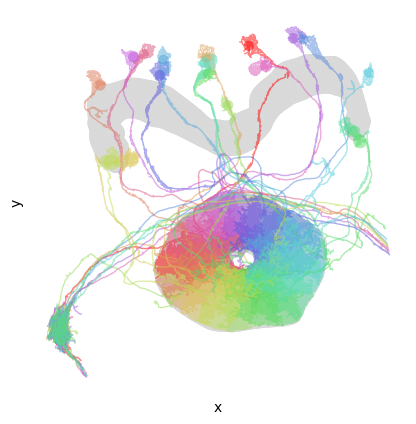

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = navis.plot2d([eb,pb],
                method='2d',
                connectors=False,
                linewidth=1,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                # color=(plt.cm.Greens(.8), plt.cm.Greys(.3)),
                alpha=1,
                radius=False,
                ax=ax,
                # volume_outlines=True,
)

for i, el in els.iterrows():
    el_skel = neu.fetch_skeletons(el['bodyId'])
    nodes = el_skel.nodes.copy()
    nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
    nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
    nodes.loc[:,'z'] = -nodes.loc[:,'z']
    nodes.head()
    el_skel.set_neuron_attributes(nodes,name='nodes')

    _ = navis.plot2d(
                    [el_skel],
                    method="2d",
                    connectors=False,
                    linewidth=1,  # Make neuron a bit thinner to emphasize the synapses
                    view=("x", "y"),
                    color=colors[i],
                    alpha=.5,
                    radius=False,
                    ax=ax,
                    # volume_outlines=True,
                )
ax.grid(False)

ax.set_xticks([])
ax.set_yticks([])
for b in ['top', 'right', 'left', 'bottom']:
        ax.spines[b].set_visible(False)

fig.savefig(figfolder / 'all_els.pdf')
fig.savefig(figfolder / 'all_els.png', transparent=True, dpi=500)


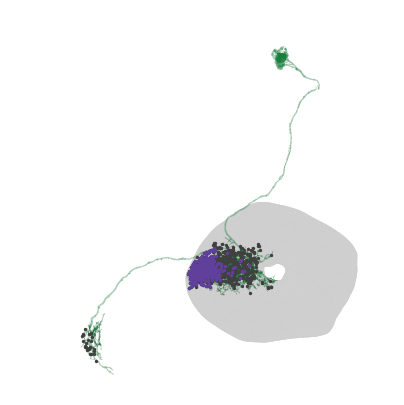

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, example_el,],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Greens(.8), plt.cm.Greys(.3)),
                alpha=.2,
                radius=True,
                ax=ax,
                # volume_outlines=True,
            )
ax.grid(False)

ax.scatter(epg_syn['x_eb'], epg_syn['y_eb'], color=plt.cm.Greys(.8), s=2,alpha=1, zorder=100)
ax.scatter(er_syn['x_eb'], er_syn['y_eb'], color=plt.cm.Purples(.8), s=2, alpha=1, zorder=100)

ax.set_xlim([-15000, 7000])
ax.set_ylim([-7000, 15000])
ax.set_xticks([])
ax.set_yticks([])
for b in ['top', 'right', 'left', 'bottom']:
        ax.spines[b].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(figfolder / 'example_el_syns.pdf')
fig.savefig(figfolder / 'example_el_syns.png', transparent=True, dpi=500)


In [25]:
# load a single R4d
er4d, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'ER4d'))
er4d_bodyId = er4d.iloc[3]['bodyId']
example_er4d = neu.fetch_skeletons(er4d_bodyId)

nodes = example_er4d.nodes.copy()
nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
nodes.loc[:,'z'] = -nodes.loc[:,'z']
nodes.head()
example_er4d.set_neuron_attributes(nodes,name='nodes')



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

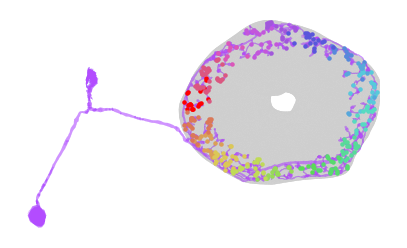

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, example_er4d,],
                method="2d",
                connectors=False,
                linewidth=1.5,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.cool(.7),plt.cm.Greys(.3)),
                alpha=.4,
                radius=True,
                ax=ax
            )
ax.grid(False)

for i, row in els.iterrows():

    syn = neu.fetch_synapse_connections(row['bodyId'],er4d_bodyId)
    syn.loc[:,('x_post', 'y_post', 'z_post')] = ebcoords.change_of_basis(syn.loc[:,('x_post', 'y_post', 'z_post')].values)
    syn.loc[:,'y_post'] = -syn.loc[:,'y_post']  #


    if i== 0:
        alpha = 1.0
    else:
        alpha = 1.

    ax.scatter(syn['x_post'], syn['y_post'], color=colors[i], s=5, alpha=alpha, label=row['bodyId'], zorder=100+i)


ax.set_xticks([])
ax.set_yticks([])
for b in ['top', 'right', 'left', 'bottom']:
        ax.spines[b].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(figfolder / 'example_er4d_syns.pdf')
fig.savefig(figfolder / 'example_er4d_syns.png',transparent=True, dpi=500)


In [27]:
# find epg - el synapses
epg_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = 'EPG'), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))
# er_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = 'ER4d'), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))
# er2_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = ['ER2_c','ER2_a', 'ER2_b', 'ER2_d']), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))
er_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = ['ER4d', 'ER2.*']), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))

add_eb_coords(epg_syn, ebcoords)
add_eb_coords(er_syn, ebcoords)
# add_eb_coords(er2_syn, ebcoords)


  0%|          | 0/9441 [00:00<?, ?it/s]

  0%|          | 0/12438 [00:00<?, ?it/s]

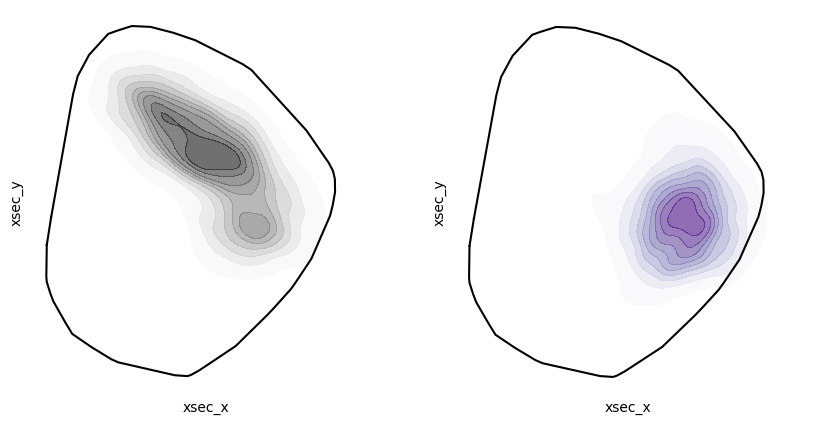

In [28]:
fig, ax= plt.subplots(1,2, figsize=(10, 5))
# sns.kdeplot(
#     data=epg_syn, x="radius", y="z_eb", fill=True, ax=ax, cmap='Greys', alpha=.6
# )
# sns.kdeplot(
#     data=er_syn, x="radius", y="z_eb", fill=True, ax=ax, cmap='Purples', alpha=.6
# )
sns.kdeplot(
    data=epg_syn, x="xsec_x", y="xsec_y", fill=True, ax=ax[0], cmap='Greys', alpha=.6
)
sns.kdeplot(
    data=er_syn, x="xsec_x", y="xsec_y", fill=True, ax=ax[1], cmap='Purples', alpha=.6
)

r,p = ebcoords.eb_vertices_xsec['radius'], ebcoords.eb_vertices_xsec['phase']
c = np.column_stack((r*np.cos(p), r*np.sin(p)))
# c = np.column_stack((ebcoords.eb_vertices_circ['radius'], ebcoords.eb_vertices[:,2]))

hull = sp.spatial.ConvexHull(c)
hull_points = c[hull.vertices,:]
for a in ax.flatten():
    a.plot(hull_points[:,0], hull_points[:,1], color='black')
    a.plot([hull_points[-1,0], hull_points[0,0]], [hull_points[-1,1], hull_points[0,1]], color='black')

    a.set_xticks([])
    a.set_yticks([])
    for b in ['top', 'right', 'left', 'bottom']:
            a.spines[b].set_visible(False)

fig.savefig(figfolder / 'epg_er_synapse_density_xsec.pdf')


In [33]:
# find epg - el synapses
c = nmp.connectomics.npt_client()
columnar_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = ['EPG', 'PEG','PEN.*']), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))
er_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = ['ER4d', 'ER2.*','ER3.*', 'ER1.*']), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))
er5_syn = neu.fetch_synapse_connections(neu.NeuronCriteria(type = ['ER5.*']), neu.NeuronCriteria(type = 'EL'), synapse_criteria=neu.SynapseCriteria(rois=('EB')))

add_eb_coords(columnar_syn, ebcoords, type='pre')
add_eb_coords(er_syn, ebcoords, type='post')
add_eb_coords(er5_syn, ebcoords, type='pre')
# add_eb_coords(er2_syn, ebcoords)

  0%|          | 0/18598 [00:00<?, ?it/s]

  0%|          | 0/24571 [00:00<?, ?it/s]

  0%|          | 0/10995 [00:00<?, ?it/s]

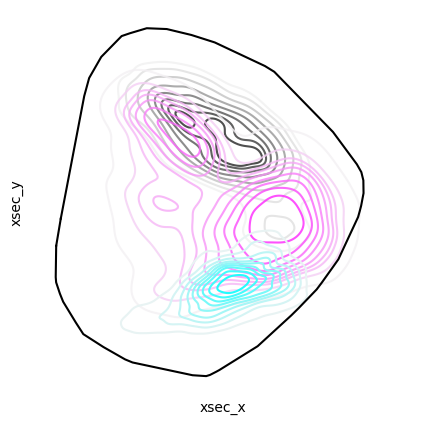

In [49]:
fig, ax= plt.subplots(figsize=(5, 5))

magentas = sns.light_palette("magenta", as_cmap=True)
cyans = sns.light_palette("cyan", as_cmap=True)

sns.kdeplot(
    data=columnar_syn, x="xsec_x", y="xsec_y", fill=False, ax=ax, cmap='Greys', alpha=.8
)
sns.kdeplot(
    data=er_syn, x="xsec_x", y="xsec_y", fill=False, ax=ax, cmap=magentas, alpha=.8
)
sns.kdeplot(
    data=er5_syn, x="xsec_x", y="xsec_y", fill=False, ax=ax, cmap=cyans, alpha=1.
)


r,p = ebcoords.eb_vertices_xsec['radius'], ebcoords.eb_vertices_xsec['phase']
c = np.column_stack((r*np.cos(p), r*np.sin(p)))
# c = np.column_stack((ebcoords.eb_vertices_circ['radius'], ebcoords.eb_vertices[:,2]))

hull = sp.spatial.ConvexHull(c)
hull_points = c[hull.vertices,:]

ax.plot(hull_points[:,0], hull_points[:,1], color='black')
ax.plot([hull_points[-1,0], hull_points[0,0]], [hull_points[-1,1], hull_points[0,1]], color='black')

ax.set_xticks([])
ax.set_yticks([])
for b in ['top', 'right', 'left', 'bottom']:
    ax.spines[b].set_visible(False)

fig.savefig(figfolder / 'columnar_er_er5_synapse_density_xsec.pdf')